In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy import stats
import plotly.graph_objs as go

plt.style.use('bmh')

In [2]:
# loading data to df

df_1 = pd.read_csv(r'C:\Users\user\!!DevRepublik\!Final_project\!Loan_risk\loan.csv') # Roma
# df_1 = pd.read_csv(r"C:\Users\User\Desktop\Phyton\Data Science\loan\loan.csv") #Alex

df_1.head()

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.



,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_1.shape

(887379, 74)

In [4]:
#new feature
df_1['solvency'] = (df_1['annual_inc'] / df_1['installment'])
df_1.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,solvency
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147.356788
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.420692
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.286375
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.000147
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1180.115061


In [5]:
df_1.replace(to_replace=['Current', 'Fully Paid', 'Issued', 'Charged Off', 'Late (31-120 days)','In Grace Period','Late (16-30 days)','Does not meet the credit policy. Status:Fully Paid','Default','Does not meet the credit policy. Status:Charged Off'],
           value= ['0','0','0','1','1','1','1','1','1','1'], 
           inplace=True)

In [6]:
df_1['loan_status'] = df_1['loan_status'].fillna(0.0).astype(int)

In [7]:
# удаляем фичи где кол-во nan > 250 000

for column in df_1:
    if sum(df_1[column].isnull()) >= 250000:
        df_1.drop(column, axis=1, inplace=True)

In [8]:
pd.options.display.max_rows = 4000
df_1.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                     51462
emp_length                    44825
home_ownership                    0
annual_inc                        4
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
url                               0
purpose                           0
title                           152
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
inq_last_6mths                   29
open_acc                    

In [9]:
# ф-ция которая меняет порядок колонок

def movecol(df_1, cols_to_move=[], ref_col='', place='After'):
    
    cols = df_1.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df_1[seg1 + seg2 + seg3])

In [10]:
# передвигаем наш таргет loan_status в самый конец

df_1 = movecol(df_1, 
             cols_to_move=['loan_status'], 
             ref_col='solvency',
             place='After')
df_1.head(1)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,solvency,loan_status
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,147.356788,0


In [11]:
df_1.shape

(887379, 53)

In [12]:
columns_to_keep_after_feature_analysys = ['addr_state','int_rate', 'term', 'installment', 
                                          'annual_inc', 'sub_grade',  'emp_title', 'home_ownership', 
                                          'purpose',  'dti', 'pub_rec', 'recoveries', 
                                          'inq_last_6mths', 'out_prncp_inv', 'collection_recovery_fee','solvency']

# A lot NAN - 'emp_length' 'total_pympt',

# funded_amnt_inv grade

In [ ]:
# # #  успешный набор фичей
# # CatBoost classifier:
# #  - ROC AUC _score:  0.93030
# #  - accuracy_score:  0.85692
# #  - f1_score:  0.83862

# columns_to_keep = ['int_rate', 'installment', 'total_pymnt', 'total_rec_prncp', 
#                    'total_rec_late_fee',  'tot_cur_bal', 'total_rev_hi_lim', 'recoveries', 
#                    'out_prncp_inv', 'collection_recovery_fee', 'inq_last_6mths',]

In [13]:
# columns_to_keep_after_feature_analysys = ['addr_state','int_rate', 'term', 'funded_amnt_inv', 
#                                           'annual_inc', 'grade',  'emp_title', 'home_ownership', 
#                                           'purpose',  'dti', 'pub_rec', 'recoveries', 
#                                           'inq_last_6mths', 'out_prncp_inv', 'collection_recovery_fee']


In [14]:
df_1 = df_1[columns_to_keep_after_feature_analysys + ['loan_status']]
df_1.head(1)

,addr_state,int_rate,term,installment,annual_inc,sub_grade,emp_title,home_ownership,purpose,dti,pub_rec,recoveries,inq_last_6mths,out_prncp_inv,collection_recovery_fee,solvency,loan_status
0,AZ,10.65,36 months,162.87,24000.0,B2,NaN,RENT,credit_card,27.65,0.0,0.0,1.0,0.0,0.0,147.356788,0


In [15]:
df_1.shape

(887379, 17)

In [16]:
df_1['loan_status'].value_counts()

0    817962
1     69417
Name: loan_status, dtype: int64

In [17]:
df_1.isnull().sum()

addr_state                     0
int_rate                       0
term                           0
installment                    0
annual_inc                     4
sub_grade                      0
emp_title                  51462
home_ownership                 0
purpose                        0
dti                            0
pub_rec                       29
recoveries                     0
inq_last_6mths                29
out_prncp_inv                  0
collection_recovery_fee        0
solvency                       4
loan_status                    0
dtype: int64

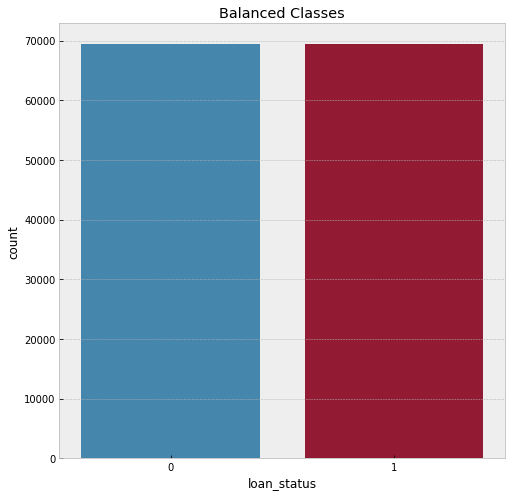

In [18]:
# Shuffle the Dataset.
shuffled_df = df_1.sample(frac=1, random_state=4)

# Put all the fraud class in a separate dataset.
fraud_df = shuffled_df.loc[shuffled_df['loan_status'] == 1]

#Randomly select 69417 observations from the non-fraud (majority class)
non_fraud_df = shuffled_df.loc[shuffled_df['loan_status'] == 0].sample(n=69417, random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([fraud_df, non_fraud_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('loan_status', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

In [19]:
normalized_df['loan_status'].value_counts()

1    69417
0    69417
Name: loan_status, dtype: int64

In [20]:
normalized_df.isnull().sum()

addr_state                    0
int_rate                      0
term                          0
installment                   0
annual_inc                    4
sub_grade                     0
emp_title                  8895
home_ownership                0
purpose                       0
dti                           0
pub_rec                      29
recoveries                    0
inq_last_6mths               29
out_prncp_inv                 0
collection_recovery_fee       0
solvency                      4
loan_status                   0
dtype: int64

In [21]:
# Shuffle the Dataset.
normalized_df = normalized_df.sample(frac=1, random_state=4)
normalized_df.head(2)

,addr_state,int_rate,term,installment,annual_inc,sub_grade,emp_title,home_ownership,purpose,dti,pub_rec,recoveries,inq_last_6mths,out_prncp_inv,collection_recovery_fee,solvency,loan_status
598381,OH,8.18,36 months,471.3,70000.0,B1,Field Sales Associate,MORTGAGE,debt_consolidation,12.7,0.0,0.0,0.0,14142.15,0.0,148.525355,1
59642,CA,9.67,36 months,256.9,55000.0,B1,Director of Advanccement,RENT,credit_card,18.3,0.0,0.0,0.0,2695.03,0.0,214.091086,0


In [22]:
normalized_df.dtypes

addr_state                  object
int_rate                   float64
term                        object
installment                float64
annual_inc                 float64
sub_grade                   object
emp_title                   object
home_ownership              object
purpose                     object
dti                        float64
pub_rec                    float64
recoveries                 float64
inq_last_6mths             float64
out_prncp_inv              float64
collection_recovery_fee    float64
solvency                   float64
loan_status                  int32
dtype: object

In [23]:
# Удаляем строки с нанами

new_data = normalized_df.dropna(axis = 0, how ='any')
new_data.shape

(129922, 17)

In [24]:
new_data.isnull().sum()

addr_state                 0
int_rate                   0
term                       0
installment                0
annual_inc                 0
sub_grade                  0
emp_title                  0
home_ownership             0
purpose                    0
dti                        0
pub_rec                    0
recoveries                 0
inq_last_6mths             0
out_prncp_inv              0
collection_recovery_fee    0
solvency                   0
loan_status                0
dtype: int64

In [25]:
# from sklearn.preprocessing import LabelEncoder

# new_data=new_data.apply(LabelEncoder().fit_transform) # label Encoding for all non-numeric columns in dataframe df
# new_data.head(2)

# Делаем LabelEncoder

In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
le = LabelEncoder()
# new_data['sub_grade'] = le.fit_transform(new_data['sub_grade'])

In [28]:
new_data['sub_grade'] = le.fit_transform(new_data['sub_grade'])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
new_data['addr_state'] = le.fit_transform(new_data['addr_state'])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
new_data['term'] = le.fit_transform(new_data['term'])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
new_data['emp_title'] = le.fit_transform(new_data['emp_title'])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
new_data['home_ownership'] = le.fit_transform(new_data['home_ownership'])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
new_data['purpose'] = le.fit_transform(new_data['purpose'])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
new_data.head(2)

,addr_state,int_rate,term,installment,annual_inc,sub_grade,emp_title,home_ownership,purpose,dti,pub_rec,recoveries,inq_last_6mths,out_prncp_inv,collection_recovery_fee,solvency,loan_status
598381,35,8.18,0,471.3,70000.0,5,19517,0,2,12.7,0.0,0.0,0.0,14142.15,0.0,148.525355,1
59642,4,9.67,0,256.9,55000.0,5,15372,4,1,18.3,0.0,0.0,0.0,2695.03,0.0,214.091086,0


In [35]:
new_data.dtypes

addr_state                   int32
int_rate                   float64
term                         int32
installment                float64
annual_inc                 float64
sub_grade                    int32
emp_title                    int32
home_ownership               int32
purpose                      int32
dti                        float64
pub_rec                    float64
recoveries                 float64
inq_last_6mths             float64
out_prncp_inv              float64
collection_recovery_fee    float64
solvency                   float64
loan_status                  int32
dtype: object

In [36]:
# train/test split

X = new_data.drop('loan_status', axis=1)
y = new_data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y)

# CatBoost modelling

In [37]:
from catboost import CatBoostClassifier

In [38]:
model_cat = CatBoostClassifier(iterations=200, depth=5, learning_rate=0.1)

model_cat.fit(X_train, y_train)

0:	learn: 0.6192373	total: 95.8ms	remaining: 19.1s
1:	learn: 0.5756004	total: 134ms	remaining: 13.2s
2:	learn: 0.5481081	total: 171ms	remaining: 11.2s
3:	learn: 0.5376979	total: 209ms	remaining: 10.2s
4:	learn: 0.5239140	total: 247ms	remaining: 9.63s
5:	learn: 0.5143032	total: 282ms	remaining: 9.11s
6:	learn: 0.5068931	total: 319ms	remaining: 8.78s
7:	learn: 0.5029613	total: 354ms	remaining: 8.5s
8:	learn: 0.4990722	total: 396ms	remaining: 8.41s
9:	learn: 0.4954912	total: 436ms	remaining: 8.29s
10:	learn: 0.4930106	total: 480ms	remaining: 8.24s
11:	learn: 0.4909100	total: 515ms	remaining: 8.06s
12:	learn: 0.4890984	total: 550ms	remaining: 7.91s
13:	learn: 0.4876186	total: 587ms	remaining: 7.8s
14:	learn: 0.4862977	total: 624ms	remaining: 7.7s
15:	learn: 0.4847272	total: 663ms	remaining: 7.62s
16:	learn: 0.4837119	total: 701ms	remaining: 7.55s
17:	learn: 0.4829240	total: 733ms	remaining: 7.41s
18:	learn: 0.4820598	total: 768ms	remaining: 7.32s
19:	learn: 0.4813658	total: 804ms	remaining

161:	learn: 0.4631704	total: 6.07s	remaining: 1.42s
162:	learn: 0.4631265	total: 6.11s	remaining: 1.39s
163:	learn: 0.4630676	total: 6.15s	remaining: 1.35s
164:	learn: 0.4629732	total: 6.18s	remaining: 1.31s
165:	learn: 0.4629000	total: 6.23s	remaining: 1.27s
166:	learn: 0.4628435	total: 6.27s	remaining: 1.24s
167:	learn: 0.4627804	total: 6.31s	remaining: 1.2s
168:	learn: 0.4626708	total: 6.35s	remaining: 1.17s
169:	learn: 0.4623043	total: 6.4s	remaining: 1.13s
170:	learn: 0.4622349	total: 6.43s	remaining: 1.09s
171:	learn: 0.4621654	total: 6.47s	remaining: 1.05s
172:	learn: 0.4621121	total: 6.51s	remaining: 1.02s
173:	learn: 0.4620452	total: 6.55s	remaining: 979ms
174:	learn: 0.4619778	total: 6.59s	remaining: 942ms
175:	learn: 0.4619165	total: 6.64s	remaining: 905ms
176:	learn: 0.4618691	total: 6.68s	remaining: 868ms
177:	learn: 0.4618340	total: 6.71s	remaining: 830ms
178:	learn: 0.4617768	total: 6.75s	remaining: 792ms
179:	learn: 0.4617322	total: 6.79s	remaining: 755ms
180:	learn: 0.

In [39]:
test_y_pred4 = model_cat.predict(X_test)

In [40]:
# make predictions on a test set and get AUC score

print("Sklearn CatBoost classifier:")
y_pred = model_cat.predict_proba(X_test)

print(f" - roc_auc_score: {roc_auc_score(y_test, y_pred[:,1]): .5f}")

Sklearn CatBoost classifier:
 - roc_auc_score:  0.83942


In [41]:
# Accuracy score, f1_score

print("Sklearn CatBoost classifier:")
print(f" - accuracy_score: {accuracy_score(y_test, test_y_pred4): .5f}")
print(f" - f1_score: {f1_score(y_test, test_y_pred4): .5f}")

Sklearn CatBoost classifier:
 - accuracy_score:  0.75444
 - f1_score:  0.72999


In [42]:
new_data.head(1)

,addr_state,int_rate,term,installment,annual_inc,sub_grade,emp_title,home_ownership,purpose,dti,pub_rec,recoveries,inq_last_6mths,out_prncp_inv,collection_recovery_fee,solvency,loan_status
598381,35,8.18,0,471.3,70000.0,5,19517,0,2,12.7,0.0,0.0,0.0,14142.15,0.0,148.525355,1


# And now scaler

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [44]:
# скейлим цифровые фичи

new_data[['int_rate', 'installment', 'annual_inc', 'dti', 'pub_rec', 'recoveries', 'inq_last_6mths', 'collection_recovery_fee', 'out_prncp_inv']] = scaler.fit_transform(new_data[['int_rate', 'installment', 'annual_inc', 'dti', 'pub_rec', 'recoveries', 'inq_last_6mths', 'collection_recovery_fee', 'out_prncp_inv']])
new_data.head(1)

# new_data[['int_rate', 'funded_amnt_inv', 'annual_inc', 'dti', 'pub_rec', 'recoveries', 'inq_last_6mths', 'collection_recovery_fee', 'out_prncp_inv']] = scaler.fit_transform(new_data[['int_rate', 'funded_amnt_inv', 'annual_inc', 'dti', 'pub_rec', 'recoveries', 'inq_last_6mths', 'collection_recovery_fee', 'out_prncp_inv']])
# new_data.head(1)



C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,addr_state,int_rate,term,installment,annual_inc,sub_grade,emp_title,home_ownership,purpose,dti,pub_rec,recoveries,inq_last_6mths,out_prncp_inv,collection_recovery_fee,solvency,loan_status
598381,35,-1.382471,0,0.109152,-0.038709,5,19517,0,2,-0.687871,-0.336723,-0.293494,-0.713103,0.948401,-0.200793,148.525355,1


In [45]:
# train/test split

X = new_data.drop('loan_status', axis=1)
y = new_data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [46]:
X.head()

,addr_state,int_rate,term,installment,annual_inc,sub_grade,emp_title,home_ownership,purpose,dti,pub_rec,recoveries,inq_last_6mths,out_prncp_inv,collection_recovery_fee,solvency
598381,35,-1.382471,0,0.109152,-0.038709,5,19517,0,2,-0.687871,-0.336723,-0.293494,-0.713103,0.948401,-0.200793,148.525355
59642,4,-1.054053,0,-0.761273,-0.256983,5,15372,4,1,-0.004004,-0.336723,-0.293494,-0.713103,-0.439815,-0.200793,214.091086
386405,45,-0.322275,0,-0.545900,-0.329741,10,25289,4,2,-0.861280,1.597391,-0.293494,0.113290,-0.217200,-0.200793,161.316341
159333,35,-0.514036,0,0.904064,-0.402500,7,30510,0,1,1.463866,-0.336723,-0.293494,-0.713103,-0.766648,-0.200793,67.456154
355126,9,-0.613223,1,-0.298373,-0.256983,8,41719,4,1,0.522329,-0.336723,-0.293494,-0.713103,0.778221,-0.200793,148.279953


In [47]:
model_cat2 = CatBoostClassifier(iterations=200, depth=5, learning_rate=0.1)

model_cat2.fit(X_train, y_train)

0:	learn: 0.6197500	total: 42ms	remaining: 8.35s
1:	learn: 0.5743884	total: 81.1ms	remaining: 8.03s
2:	learn: 0.5487939	total: 120ms	remaining: 7.9s
3:	learn: 0.5384140	total: 160ms	remaining: 7.82s
4:	learn: 0.5239113	total: 199ms	remaining: 7.75s
5:	learn: 0.5145295	total: 246ms	remaining: 7.96s
6:	learn: 0.5092207	total: 294ms	remaining: 8.1s
7:	learn: 0.5049115	total: 332ms	remaining: 7.96s
8:	learn: 0.5014456	total: 370ms	remaining: 7.86s
9:	learn: 0.4970429	total: 412ms	remaining: 7.83s
10:	learn: 0.4944565	total: 454ms	remaining: 7.81s
11:	learn: 0.4913837	total: 500ms	remaining: 7.83s
12:	learn: 0.4893522	total: 540ms	remaining: 7.77s
13:	learn: 0.4879151	total: 580ms	remaining: 7.71s
14:	learn: 0.4860756	total: 623ms	remaining: 7.68s
15:	learn: 0.4849409	total: 661ms	remaining: 7.6s
16:	learn: 0.4840534	total: 694ms	remaining: 7.47s
17:	learn: 0.4833003	total: 735ms	remaining: 7.43s
18:	learn: 0.4818009	total: 775ms	remaining: 7.38s
19:	learn: 0.4810739	total: 812ms	remaining:

164:	learn: 0.4628350	total: 6.68s	remaining: 1.42s
165:	learn: 0.4627796	total: 6.72s	remaining: 1.38s
166:	learn: 0.4627069	total: 6.76s	remaining: 1.34s
167:	learn: 0.4626541	total: 6.8s	remaining: 1.3s
168:	learn: 0.4625847	total: 6.85s	remaining: 1.25s
169:	learn: 0.4625448	total: 6.89s	remaining: 1.22s
170:	learn: 0.4624891	total: 6.94s	remaining: 1.18s
171:	learn: 0.4624241	total: 6.98s	remaining: 1.14s
172:	learn: 0.4623781	total: 7.01s	remaining: 1.09s
173:	learn: 0.4623159	total: 7.05s	remaining: 1.05s
174:	learn: 0.4622717	total: 7.09s	remaining: 1.01s
175:	learn: 0.4621998	total: 7.14s	remaining: 973ms
176:	learn: 0.4621042	total: 7.18s	remaining: 933ms
177:	learn: 0.4620292	total: 7.22s	remaining: 893ms
178:	learn: 0.4619513	total: 7.26s	remaining: 852ms
179:	learn: 0.4618748	total: 7.31s	remaining: 812ms
180:	learn: 0.4618139	total: 7.36s	remaining: 772ms
181:	learn: 0.4617526	total: 7.4s	remaining: 732ms
182:	learn: 0.4616113	total: 7.44s	remaining: 691ms
183:	learn: 0.4

In [48]:
test_y_pred2 = model_cat2.predict(X_test)

In [49]:
# make predictions on a test set and get AUC score

print("Sklearn CatBoost classifier:")
y_pred2 = model_cat2.predict_proba(X_test)

print(f" - roc_auc_score: {roc_auc_score(y_test, y_pred2[:,1]): .5f}")

Sklearn CatBoost classifier:
 - roc_auc_score:  0.83898


In [50]:
# Accuracy score, f1_score

print("Sklearn CatBoost classifier:")
print(f" - accuracy_score: {accuracy_score(y_test, test_y_pred2): .5f}")
print(f" - f1_score: {f1_score(y_test, test_y_pred2): .5f}")

Sklearn CatBoost classifier:
 - accuracy_score:  0.75302
 - f1_score:  0.72944


# CatBoost Feature Importances

In [51]:
importances = model_cat2.feature_importances_
indices = np.argsort(importances)[::-1] 

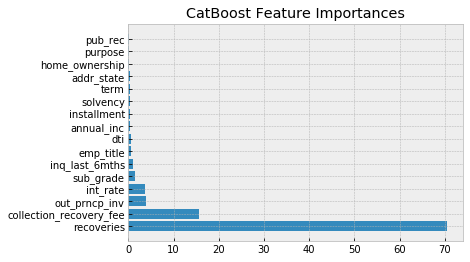

In [52]:
plt.barh(X_train.columns[indices], importances[indices])
plt.title('CatBoost Feature Importances')
plt.show()

# New df with only 10 features

In [53]:
# acc 0.837

new_df = pd.DataFrame(new_data, columns = ['int_rate', 'sub_grade', 'recoveries', 'emp_title', 'annual_inc', 'installment', 'term', 'out_prncp_inv', 'collection_recovery_fee', 'inq_last_6mths', 'loan_status'])
new_df.shape

(129922, 11)

In [54]:
# acc 0.83327

# new_df = pd.DataFrame(new_data, columns = ['int_rate', 'sub_grade', 'recoveries', 'out_prncp_inv', 'collection_recovery_fee', 'inq_last_6mths', 'loan_status'])
# new_df.shape

In [55]:
# train/test split

X = new_df.drop('loan_status', axis=1)
y = new_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [56]:
model_cat3 = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1)

model_cat3.fit(X_train, y_train)

0:	learn: 0.6167752	total: 50.3ms	remaining: 10s
1:	learn: 0.5744790	total: 102ms	remaining: 10.1s
2:	learn: 0.5487178	total: 148ms	remaining: 9.7s
3:	learn: 0.5320663	total: 190ms	remaining: 9.32s
4:	learn: 0.5197359	total: 236ms	remaining: 9.2s
5:	learn: 0.5121403	total: 283ms	remaining: 9.15s
6:	learn: 0.5067431	total: 326ms	remaining: 8.98s
7:	learn: 0.5020260	total: 366ms	remaining: 8.79s
8:	learn: 0.4978255	total: 410ms	remaining: 8.71s
9:	learn: 0.4942742	total: 456ms	remaining: 8.66s
10:	learn: 0.4917998	total: 498ms	remaining: 8.56s
11:	learn: 0.4896397	total: 543ms	remaining: 8.51s
12:	learn: 0.4877729	total: 595ms	remaining: 8.55s
13:	learn: 0.4863172	total: 638ms	remaining: 8.48s
14:	learn: 0.4850235	total: 682ms	remaining: 8.41s
15:	learn: 0.4836814	total: 725ms	remaining: 8.34s
16:	learn: 0.4820867	total: 771ms	remaining: 8.3s
17:	learn: 0.4811075	total: 814ms	remaining: 8.23s
18:	learn: 0.4803694	total: 857ms	remaining: 8.17s
19:	learn: 0.4797364	total: 900ms	remaining: 

162:	learn: 0.4618550	total: 7.58s	remaining: 1.72s
163:	learn: 0.4617666	total: 7.62s	remaining: 1.67s
164:	learn: 0.4616694	total: 7.67s	remaining: 1.63s
165:	learn: 0.4615951	total: 7.71s	remaining: 1.58s
166:	learn: 0.4615331	total: 7.76s	remaining: 1.53s
167:	learn: 0.4614354	total: 7.8s	remaining: 1.49s
168:	learn: 0.4613624	total: 7.84s	remaining: 1.44s
169:	learn: 0.4612816	total: 7.89s	remaining: 1.39s
170:	learn: 0.4612051	total: 7.93s	remaining: 1.34s
171:	learn: 0.4611295	total: 8s	remaining: 1.3s
172:	learn: 0.4610140	total: 8.05s	remaining: 1.26s
173:	learn: 0.4609636	total: 8.1s	remaining: 1.21s
174:	learn: 0.4609150	total: 8.15s	remaining: 1.16s
175:	learn: 0.4608421	total: 8.19s	remaining: 1.12s
176:	learn: 0.4607755	total: 8.23s	remaining: 1.07s
177:	learn: 0.4607064	total: 8.28s	remaining: 1.02s
178:	learn: 0.4606381	total: 8.32s	remaining: 976ms
179:	learn: 0.4605705	total: 8.36s	remaining: 929ms
180:	learn: 0.4604557	total: 8.41s	remaining: 883ms
181:	learn: 0.4603

In [57]:
test_y_pred3 = model_cat3.predict(X_test)

In [58]:
# make predictions on a test set and get AUC score

print("Sklearn CatBoost classifier:")
y_pred3 = model_cat3.predict_proba(X_test)

print(f" - roc_auc_score: {roc_auc_score(y_test, y_pred3[:,1]): .5f}")

Sklearn CatBoost classifier:
 - roc_auc_score:  0.83714


In [59]:
# Accuracy score, f1_score

print("Sklearn CatBoost classifier:")
print(f" - accuracy_score: {accuracy_score(y_test, test_y_pred3): .5f}")
print(f" - f1_score: {f1_score(y_test, test_y_pred3): .5f}")

Sklearn CatBoost classifier:
 - accuracy_score:  0.75096
 - f1_score:  0.72592


# Строим модель и наны не удаляем и не скейлим

In [60]:
df_Nan = pd.DataFrame(normalized_df, columns = ['int_rate', 'recoveries', 'loan_status'])
df_Nan.shape

(138834, 3)

In [61]:
df_Nan.head(1)

,int_rate,recoveries,loan_status
598381,8.18,0.0,1


In [62]:
# train/test split

X = df_Nan.drop('loan_status', axis=1)
y = df_Nan['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [63]:
model_cat4 = CatBoostClassifier(iterations=200, depth=5, learning_rate=0.1)

model_cat4.fit(X_train, y_train)

0:	learn: 0.6221087	total: 43.2ms	remaining: 8.59s
1:	learn: 0.5828868	total: 79.6ms	remaining: 7.88s
2:	learn: 0.5600858	total: 117ms	remaining: 7.7s
3:	learn: 0.5467672	total: 157ms	remaining: 7.7s
4:	learn: 0.5385329	total: 193ms	remaining: 7.53s
5:	learn: 0.5326518	total: 228ms	remaining: 7.37s
6:	learn: 0.5284714	total: 269ms	remaining: 7.42s
7:	learn: 0.5254664	total: 313ms	remaining: 7.52s
8:	learn: 0.5228184	total: 360ms	remaining: 7.64s
9:	learn: 0.5210383	total: 403ms	remaining: 7.66s
10:	learn: 0.5195432	total: 444ms	remaining: 7.63s
11:	learn: 0.5181393	total: 482ms	remaining: 7.55s
12:	learn: 0.5171396	total: 524ms	remaining: 7.54s
13:	learn: 0.5164143	total: 563ms	remaining: 7.47s
14:	learn: 0.5156645	total: 601ms	remaining: 7.41s
15:	learn: 0.5150215	total: 638ms	remaining: 7.34s
16:	learn: 0.5145166	total: 676ms	remaining: 7.28s
17:	learn: 0.5141274	total: 711ms	remaining: 7.18s
18:	learn: 0.5137409	total: 746ms	remaining: 7.1s
19:	learn: 0.5134608	total: 786ms	remainin

163:	learn: 0.5022847	total: 5.92s	remaining: 1.3s
164:	learn: 0.5022587	total: 5.95s	remaining: 1.26s
165:	learn: 0.5022004	total: 5.98s	remaining: 1.23s
166:	learn: 0.5020783	total: 6.02s	remaining: 1.19s
167:	learn: 0.5020353	total: 6.05s	remaining: 1.15s
168:	learn: 0.5020232	total: 6.08s	remaining: 1.11s
169:	learn: 0.5019709	total: 6.11s	remaining: 1.08s
170:	learn: 0.5019376	total: 6.14s	remaining: 1.04s
171:	learn: 0.5019222	total: 6.17s	remaining: 1s
172:	learn: 0.5018939	total: 6.2s	remaining: 968ms
173:	learn: 0.5018508	total: 6.24s	remaining: 932ms
174:	learn: 0.5018283	total: 6.27s	remaining: 896ms
175:	learn: 0.5017988	total: 6.31s	remaining: 860ms
176:	learn: 0.5017758	total: 6.34s	remaining: 824ms
177:	learn: 0.5017593	total: 6.37s	remaining: 788ms
178:	learn: 0.5017240	total: 6.41s	remaining: 751ms
179:	learn: 0.5016866	total: 6.44s	remaining: 715ms
180:	learn: 0.5016547	total: 6.47s	remaining: 679ms
181:	learn: 0.5016363	total: 6.5s	remaining: 643ms
182:	learn: 0.5016

In [64]:
test_y_pred4 = model_cat4.predict(X_test)

In [65]:
# make predictions on a test set and get AUC score

print("Sklearn CatBoost classifier:")
y_pred4 = model_cat4.predict_proba(X_test)

print(f" - roc_auc_score: {roc_auc_score(y_test, y_pred4[:,1]): .5f}")

Sklearn CatBoost classifier:
 - roc_auc_score:  0.81165


In [66]:
# Accuracy score, f1_score

print("Sklearn CatBoost classifier:")
print(f" - accuracy_score: {accuracy_score(y_test, test_y_pred4): .5f}")
print(f" - f1_score: {f1_score(y_test, test_y_pred4): .5f}")

Sklearn CatBoost classifier:
 - accuracy_score:  0.72013
 - f1_score:  0.69606
